# Sec Recon Network Visualization
This notebook is for the visualization of the Secretory Pathway Reconstruction. Here we try different approaches  the visualization. First, we generate a python dictionary with all the necessary information that will be used for downstream analysys. The first analysis is bases on a dimensionality reduction of the data set for UMAP plotting of the genes. In the second analysis we generate a network of the Sec Recon in which all the nodes represent genes interconnected by the processes they share.

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from scipy.spatial import ConvexHull

from itertools import combinations

from google_sheet import GoogleSheet
from utils import get_gene_color, flatten_processes, adjust_color_alpha, categorize_location, integrate_dicts

## 1 Generate a "gene_dict" dictionary with all the necessary information stored into it

In [2]:
##### ----- Generate datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1L6qQQs48OdFd-mJcVqov_rSDoV90Ta0kib6UpL81OJQ'

# Initialize the GoogleSheet object
gsheet_file = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sec_recon_sheet = 'SecRecon'
ontology_sheet = 'Ontology'
complex_info_sheet = 'Complex Information'

secrecon = gsheet_file.read_google_sheet(sec_recon_sheet)
ontology = gsheet_file.read_google_sheet(ontology_sheet)
complex_info = gsheet_file.read_google_sheet(complex_info_sheet)

In [3]:
#Generate dictionaries

# Processes Dictionaries
subprocess_dict = {}
process_dict = {}
subsystem_dict = {}

for i, row in ontology.iterrows():
    system, subsystem, process, subprocess = row['System'], row['Subsystem'], row['Process'], row['Subprocess']
    
    # Subprocess dictionary
    if pd.notna(subprocess):
        subprocess_dict[subprocess] = {
            'Process': process,
            'Subsystem': subsystem,
            'System': system
        }
    
    # Process dictionary
    if pd.notna(process):
        process_dict[process] = {
            'Subsystem': subsystem,
            'System': system
        }
    
    # Subsystem dictionary
    if pd.notna(subsystem):
        subsystem_dict[subsystem] = {
            'System': system
        }


# Generate lists for each category for "gene_dict" processes reorganization
subprocesses = set(list(ontology['Subprocess'].dropna()))
processes = set(list(ontology['Process'].dropna()))
subsystems = set(list(ontology['Subsystem'].dropna()))
systems = set(list(ontology['System'].dropna()))

# Gene dict
gene_dict = {}
secrecon = secrecon.fillna('')
for index, row in secrecon.iterrows():
    gene = row['GENE SYMBOL']
    
    # Add processes
    generic_processes = row[['Process 1', 'Process 2', 'Process 3', 'Process 4', 'Process 5',
                     'Process 6', 'Process 7', 'Process 8', 'Process 9']].dropna().tolist()
    
    systems_list = []
    subsystems_list = []
    processes_list = []
    subprocesses_list = []
    for proc in generic_processes:
        proc = proc.strip()  # Remove leading and trailing whitespace
        if proc in systems:
            systems_list.append(proc)
        elif proc in subsystems:
            subsystems_list.append(proc)
            systems_list.append(subsystem_dict[proc]['System'])
        elif proc in processes:
            processes_list.append(proc)
            subsystems_list.append(process_dict[proc]['Subsystem'])
            systems_list.append(process_dict[proc]['System'])
        elif proc in subprocesses:
            subprocesses_list.append(proc)
            processes_list.append(subprocess_dict[proc]['Process'])
            subsystems_list.append(subprocess_dict[proc]['Subsystem'])
            systems_list.append(subprocess_dict[proc]['System'])
    
    systems_list = list(set(systems_list))
    subsystems_list = list(set(subsystems_list))
    processes_list = list(set(processes_list))
    subprocesses_list = list(set(subprocesses_list))

                
    # Add subcellular localizations
    if (row['Subcellular Localization']=='') or (pd.isna(row['Subcellular Localization'])):
        localization = ['Unknown']
    else:
        localization = row['Subcellular Localization'].split(', ')
        
    # Add Complexes
    if row['HUMAN PROTEIN COMPLEX']!='':
        complexes = row['HUMAN PROTEIN COMPLEX'].split('; ')
    elif (row['HUMAN PROTEIN COMPLEX']=='') and (row['CHO PROTEIN COMPLEX']!=''):
        complexes = row['CHO PROTEIN COMPLEX'].split('; ')
    else:
        complexes = row['MOUSE PROTEIN COMPLEX'].split('; ')

    # Integrate all the information into gene_dict
    gene_dict[gene] = {'systems': systems_list,
                       'subsystems': subsystems_list,
                       'processes': processes_list,
                       'subprocesses': subprocesses_list, 
                       'subcellular_localization': localization,
                       'protein_complex':complexes}#,
                       #'Expression': Expression_Value}

In [4]:
# Genes with no subcellular localization
count = 0
for key in gene_dict:
    if gene_dict[key]['subcellular_localization'] == ['Unknown']:
        print(key,gene_dict[key]['subcellular_localization'])
        count += 1
        
print(count)

ALG1L ['Unknown']
ART1 ['Unknown']
HSP90AA5P ['Unknown']
HSP90AB3P ['Unknown']
HSP90AB4P ['Unknown']
MICAL2 ['Unknown']
NAT8B ['Unknown']
RYR1 ['Unknown']
RYR2 ['Unknown']
RYR3 ['Unknown']
SEC1P ['Unknown']
TBC1D12 ['Unknown']
BIM ['Unknown']
CASQ2 ['Unknown']
CNIH3 ['Unknown']
DNAJB3 ['Unknown']
16


In [5]:
with open('gene_dict.pkl', 'wb') as f:
    pickle.dump(gene_dict, f)

## 2 Dimensionality reduction / one hot encoding for UMAP visualization

In [ ]:
from sklearn.neighbors import NearestNeighbors
import umap
import igraph as ig
import leidenalg as la
import seaborn as sns
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# One hot encoding

# Step 1: Flatten the data
flattened_data = []
for gene, attributes in gene_dict.items():
    for attribute_key, values in attributes.items():
        # Skip 'subcellular_localization'
        if attribute_key == 'subcellular_localization':
            continue
        if not isinstance(values, list):  # Ensure values are in a list
            values = [values]
        for value in values:
            if value:  # Skip empty values
                flattened_data.append({
                    'gene': gene,
                    'attribute_type': attribute_key,
                    'attribute_value': value
                })

# Convert flattened data into a DataFrame
df = pd.DataFrame(flattened_data)

# Step 2: One-hot encode 'attribute_value'
one_hot_encoded_df = pd.get_dummies(df, columns=['attribute_value'], prefix='', prefix_sep='')

# Merge 'attribute_type' back for handling 'complex' attributes
one_hot_encoded_df = one_hot_encoded_df.merge(df[['gene', 'attribute_type']], left_index=True, right_index=True, how='left')

# Step 3: Apply multiplier for 'complex' attributes
complex_multiplier = 2
for index, row in one_hot_encoded_df.iterrows():
    if row['attribute_type_x'] == 'protein_complex':
        # Apply the multiplier to all one-hot encoded columns for this row, except 'gene' and 'attribute_type'
        for col in one_hot_encoded_df.columns.difference(['gene', 'attribute_type']):
            one_hot_encoded_df.at[index, col] *= complex_multiplier

# Drop the 'attribute_type' column as it's no longer needed
one_hot_encoded_df = one_hot_encoded_df.drop(columns=['attribute_type_x', 'gene_y', 'attribute_type_y'], errors='ignore')

# Step 4: Group by 'gene' and sum to aggregate attributes
final_encoded_df = one_hot_encoded_df.groupby('gene_x').sum().reset_index()

In [ ]:
# Prepare the data (excluding the gene column for the KNN input)
X = final_encoded_df.drop('gene_x', axis=1)

# Consistent distance metric
distance_metric = 'euclidean'  # Choose 'euclidean', 'cosine', etc.

In [ ]:
# Initialize the KNN model with consistent n_neighbors
n_neighbors = 20  # Adjust as needed
knn = NearestNeighbors(n_neighbors=n_neighbors, metric=distance_metric)
knn.fit(X)
distances, indices = knn.kneighbors(X)

In [ ]:
# Apply UMAP with consistent parameters
reducer = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=0.01,  # Adjust as needed
    n_components=2,
    spread=40,  # Adjust as needed
    random_state=42,
    metric=distance_metric
)
embedding = reducer.fit_transform(X)

In [ ]:
# Create a Graph for Leiden Algorithm
G = nx.Graph()
for idx, neighbors in enumerate(indices):
    for neighbor in neighbors:
        G.add_edge(idx, neighbor)

# Convert to iGraph
ig_graph = ig.Graph.from_networkx(G)

# Apply Leiden Algorithm with adjustable resolution
resolution_parameter = 1.4
partition = la.find_partition(ig_graph, la.RBConfigurationVertexPartition, 
                              resolution_parameter=resolution_parameter)

# Visualize UMAP with Leiden Clusters
plt.figure(figsize=(12, 8))
cluster_membership = np.array(partition.membership)

# Find unique clusters
unique_clusters = np.unique(cluster_membership)

# Create a color map
colors = plt.cm.get_cmap('viridis', len(unique_clusters))

# Plot each cluster with its specific color
for cluster_id in unique_clusters:
    plt.scatter(
        embedding[cluster_membership == cluster_id, 0],
        embedding[cluster_membership == cluster_id, 1],
        color=colors(cluster_id),
        label=f'Cluster {cluster_id}',
        s=40,  # Adjust point size
        alpha=0.8  # Adjust transparency
    )

plt.title('UMAP Projection with Leiden Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster ID')  # Add a legend
plt.savefig('umap_leiden_clusters.png', dpi=300)
plt.show()

In [ ]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.4, 0.7, 0.9, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.8, 0.4, 0.0, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

# Extract subcellular localization for each gene
subcellular_localization_df = pd.DataFrame(
    [(gene, locs[0]) for gene, attrs in gene_dict.items() for locs in [attrs.get('subcellular_localization', [''])] if locs],
    columns=['gene_x', 'subcellular_localization'])


# Convert UMAP embedding to a DataFrame
embedding_df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])

# Add a 'gene' column from your original DataFrame for alignment
embedding_df['gene_x'] = final_encoded_df['gene_x'].values

# Merge the UMAP results with subcellular localization
umap_localization_df = pd.merge(embedding_df, subcellular_localization_df, on='gene_x')

# Now plot with color coding
plt.figure(figsize=(12, 8))
for loc, color in localization_colors.items():
    # Find the subset of the data frame that corresponds to the current localization
    subset = umap_localization_df[umap_localization_df['subcellular_localization'] == loc]
    # Plot this subset with the predefined color
    plt.scatter(subset['UMAP_1'], subset['UMAP_2'], label=loc, color=color, s=50, alpha=0.5)

plt.legend(prop={'size': 8}, loc='lower left', bbox_to_anchor=(1.05, 0.4))
plt.subplots_adjust(right=0.75)

plt.title('2D UMAP Projection Colored by Subcellular Localization')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## 3. Network Visualization

In [6]:
from math import sqrt, ceil
import networkx as nx

### 3.1 Generate the network

In [7]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
SUBPROCESSES_WEIGHT = 2
PROCESS_WEIGHT = 1.5
SUBSYSTEM_WEIGHT = 1.0
SYSTEM_WEIGHT = 0.75
COMPLEX_WEIGHT = 2

# Add edges to the nodes
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    
    # Calculate shared subprocesses
    if (gene_dict[gene1]['subprocesses']==[]) or (gene_dict[gene2]['subprocesses']==[]):
        shared_subprocess = 0
    else:
        shared_subprocess = len(set(gene_dict[gene1]['subprocesses']).intersection(gene_dict[gene2]['subprocesses']))

    # Calculate shared processes
    if (gene_dict[gene1]['processes']==[]) or (gene_dict[gene2]['processes']==[]):
        shared_process = 0
    else:
        shared_process = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
        
    # Calculate shared subsystem
    if (gene_dict[gene1]['subsystems']==[]) or (gene_dict[gene2]['subsystems']==[]):
        shared_subsystem = 0
    else:
        shared_subsystem = len(set(gene_dict[gene1]['subsystems']).intersection(gene_dict[gene2]['subsystems']))
        
    # Calculate shared system
    if (gene_dict[gene1]['systems']==[]) or (gene_dict[gene2]['systems']==[]):
        shared_system = 0
    else:
        shared_system = len(set(gene_dict[gene1]['systems']).intersection(gene_dict[gene2]['systems']))
        
    # Check for shared complex
    if (gene_dict[gene1]['protein_complex']==['']) or (gene_dict[gene2]['protein_complex']==['']):
        shared_complex = 0
    else:
        shared_complex = len(set(gene_dict[gene1]['protein_complex'] or []).intersection(gene_dict[gene2]['protein_complex'] or []))
        
    shared_subprocess = shared_subprocess*SUBPROCESSES_WEIGHT
    shared_process = shared_process*PROCESS_WEIGHT
    shared_subsystem = shared_subsystem*SUBSYSTEM_WEIGHT
    shared_system = shared_system*SYSTEM_WEIGHT
    shared_complex = shared_complex*COMPLEX_WEIGHT
    edge_weight = shared_subprocess + shared_process + shared_subsystem + shared_system + shared_complex
    G.add_edge(gene1, gene2, weight=edge_weight)
    

# Draw the graph layout
pos = nx.spring_layout(G, seed=42, iterations=60, k=1)

### 3.2 Reorganize nodes at the edge

In [8]:
# Initialize a dictionary to track the highest weight for each node
highest_weight = {}

# Iterate over all edges to update the highest weight for each node
for u, v, data in G.edges(data=True):
    weight = data['weight']
    # Update the highest weight for nodes u and v
    if u not in highest_weight or highest_weight[u] < weight:
        highest_weight[u] = weight
    if v not in highest_weight or highest_weight[v] < weight:
        highest_weight[v] = weight

# Initialize the set of low_weight_nodes
low_weight_nodes = set()
# Add nodes to the set if their highest weight is below 1
for node, weight in highest_weight.items():
    if weight < 1:
        low_weight_nodes.add(node)
        
# Calculate layout bounds to help define the rectangle area
x_values, y_values = zip(*pos.values())
plot_width = max(x_values) - min(x_values)
plot_height = max(y_values) - min(y_values)

# Define the rectangle's bottom right corner and dimensions
x_offset = plot_width * 0.1  # Increase to move the rectangle further to the right
y_offset = plot_height * 0.1  # Increase to move the rectangle further down
rect_width = plot_width * 0.15  # 15% of the plot width
rect_height = plot_height * 0.15  # 15% of the plot height
rect_bottom_right_x = max(x_values) + x_offset
rect_bottom_right_y = min(y_values) - y_offset

# Calculate layout bounds to help define the rectangle area
x_values, y_values = zip(*pos.values())
min_x_val, max_x_val = min(x_values), max(x_values)  
min_y_val, max_y_val = min(y_values), max(y_values)

# Calculate the number of low-weight edge nodes for grid dimension calculation
num_low_weight_nodes = len(low_weight_nodes)
cols = int(round(sqrt(num_low_weight_nodes)))
rows = int(ceil(num_low_weight_nodes / cols))

# Calculate positions within the rectangle for each low-weight edge node
for i, node in enumerate(low_weight_nodes):
    col = i % cols
    row = i // cols
    
    # Calculate grid cell position
    new_x = rect_bottom_right_x - rect_width + (col + 1) * (rect_width / (cols + 1))
    new_y = rect_bottom_right_y + (row + 1) * (rect_height / (rows + 1))
    
    # Update position
    pos[node] = (new_x, new_y)

# Add positions as node attributes
for node, (x, y) in pos.items():
    G.nodes[node]['x'] = x
    G.nodes[node]['y'] = y

In [9]:
# Save the network as a GraphML
nx.write_graphml(G, 'Network/sec_recon_network.graphml')

### 3.3 Create the plot color-coding by subcellular localization

In [10]:
localization_colors = {
    'Actin Cytoskeleton': (0.7, 0.4, 0.2, 1.0),
    'Centrosome': (0.0, 0.5, 0.5, 1.0),
    'ERGIC': (1.0, 0.6, 0.0, 1.0),
    'Endosome': (0.0, 0.7, 0.3, 1.0), 
    'Recycling Endosome': (0.3, 0.0, 0.7, 1.0),
    'Late Endosome': (0.8, 0.0, 0.5, 1.0),
    'Early Endosome': (0.7, 0.0, 0.4, 1.0), 
    'Plasma Membrane': (0.5, 0.5, 0.0, 1.0), 
    'Golgi': (0.1, 0.9, 0.1, 1.0), 
    'cis-Golgi': (0.2, 0.8, 0.6, 1.0),
    'trans-Golgi': (0.4, 0.8, 0.4, 1.0), 
    'Nucleus': (0.9, 0.1, 0.1, 1.0),
    'Nucleolus': (0.5, 0.1, 0.1, 1.0),
    'Phagosome': (0.6, 0.3, 0.0, 1.0),
    'Proteasome': (0.3, 0.3, 0.9, 1.0),
    'Mitochondria': (0.9, 0.5, 0.5, 1.0),
    'Lysosome': (0.5, 0.9, 0.8, 1.0),  
    'Cytosol': (0.3, 0.8, 0.95, 1.0),
    'Cytoplasm': (0.4, 0.7, 0.9, 1.0),
    'Endoplasmic Reticulum': (0.7, 0.7, 0.3, 1.0),
    'Secreted': (0.8, 0.4, 0.0, 1.0),
    'Stress Granule': (0.9, 0.3, 0.05, 1.0),
    'Translation': (0.8, 0.2, 0.8, 1.0),
    'Unknown': (0.0, 0.0, 0.0, 1.0)
}

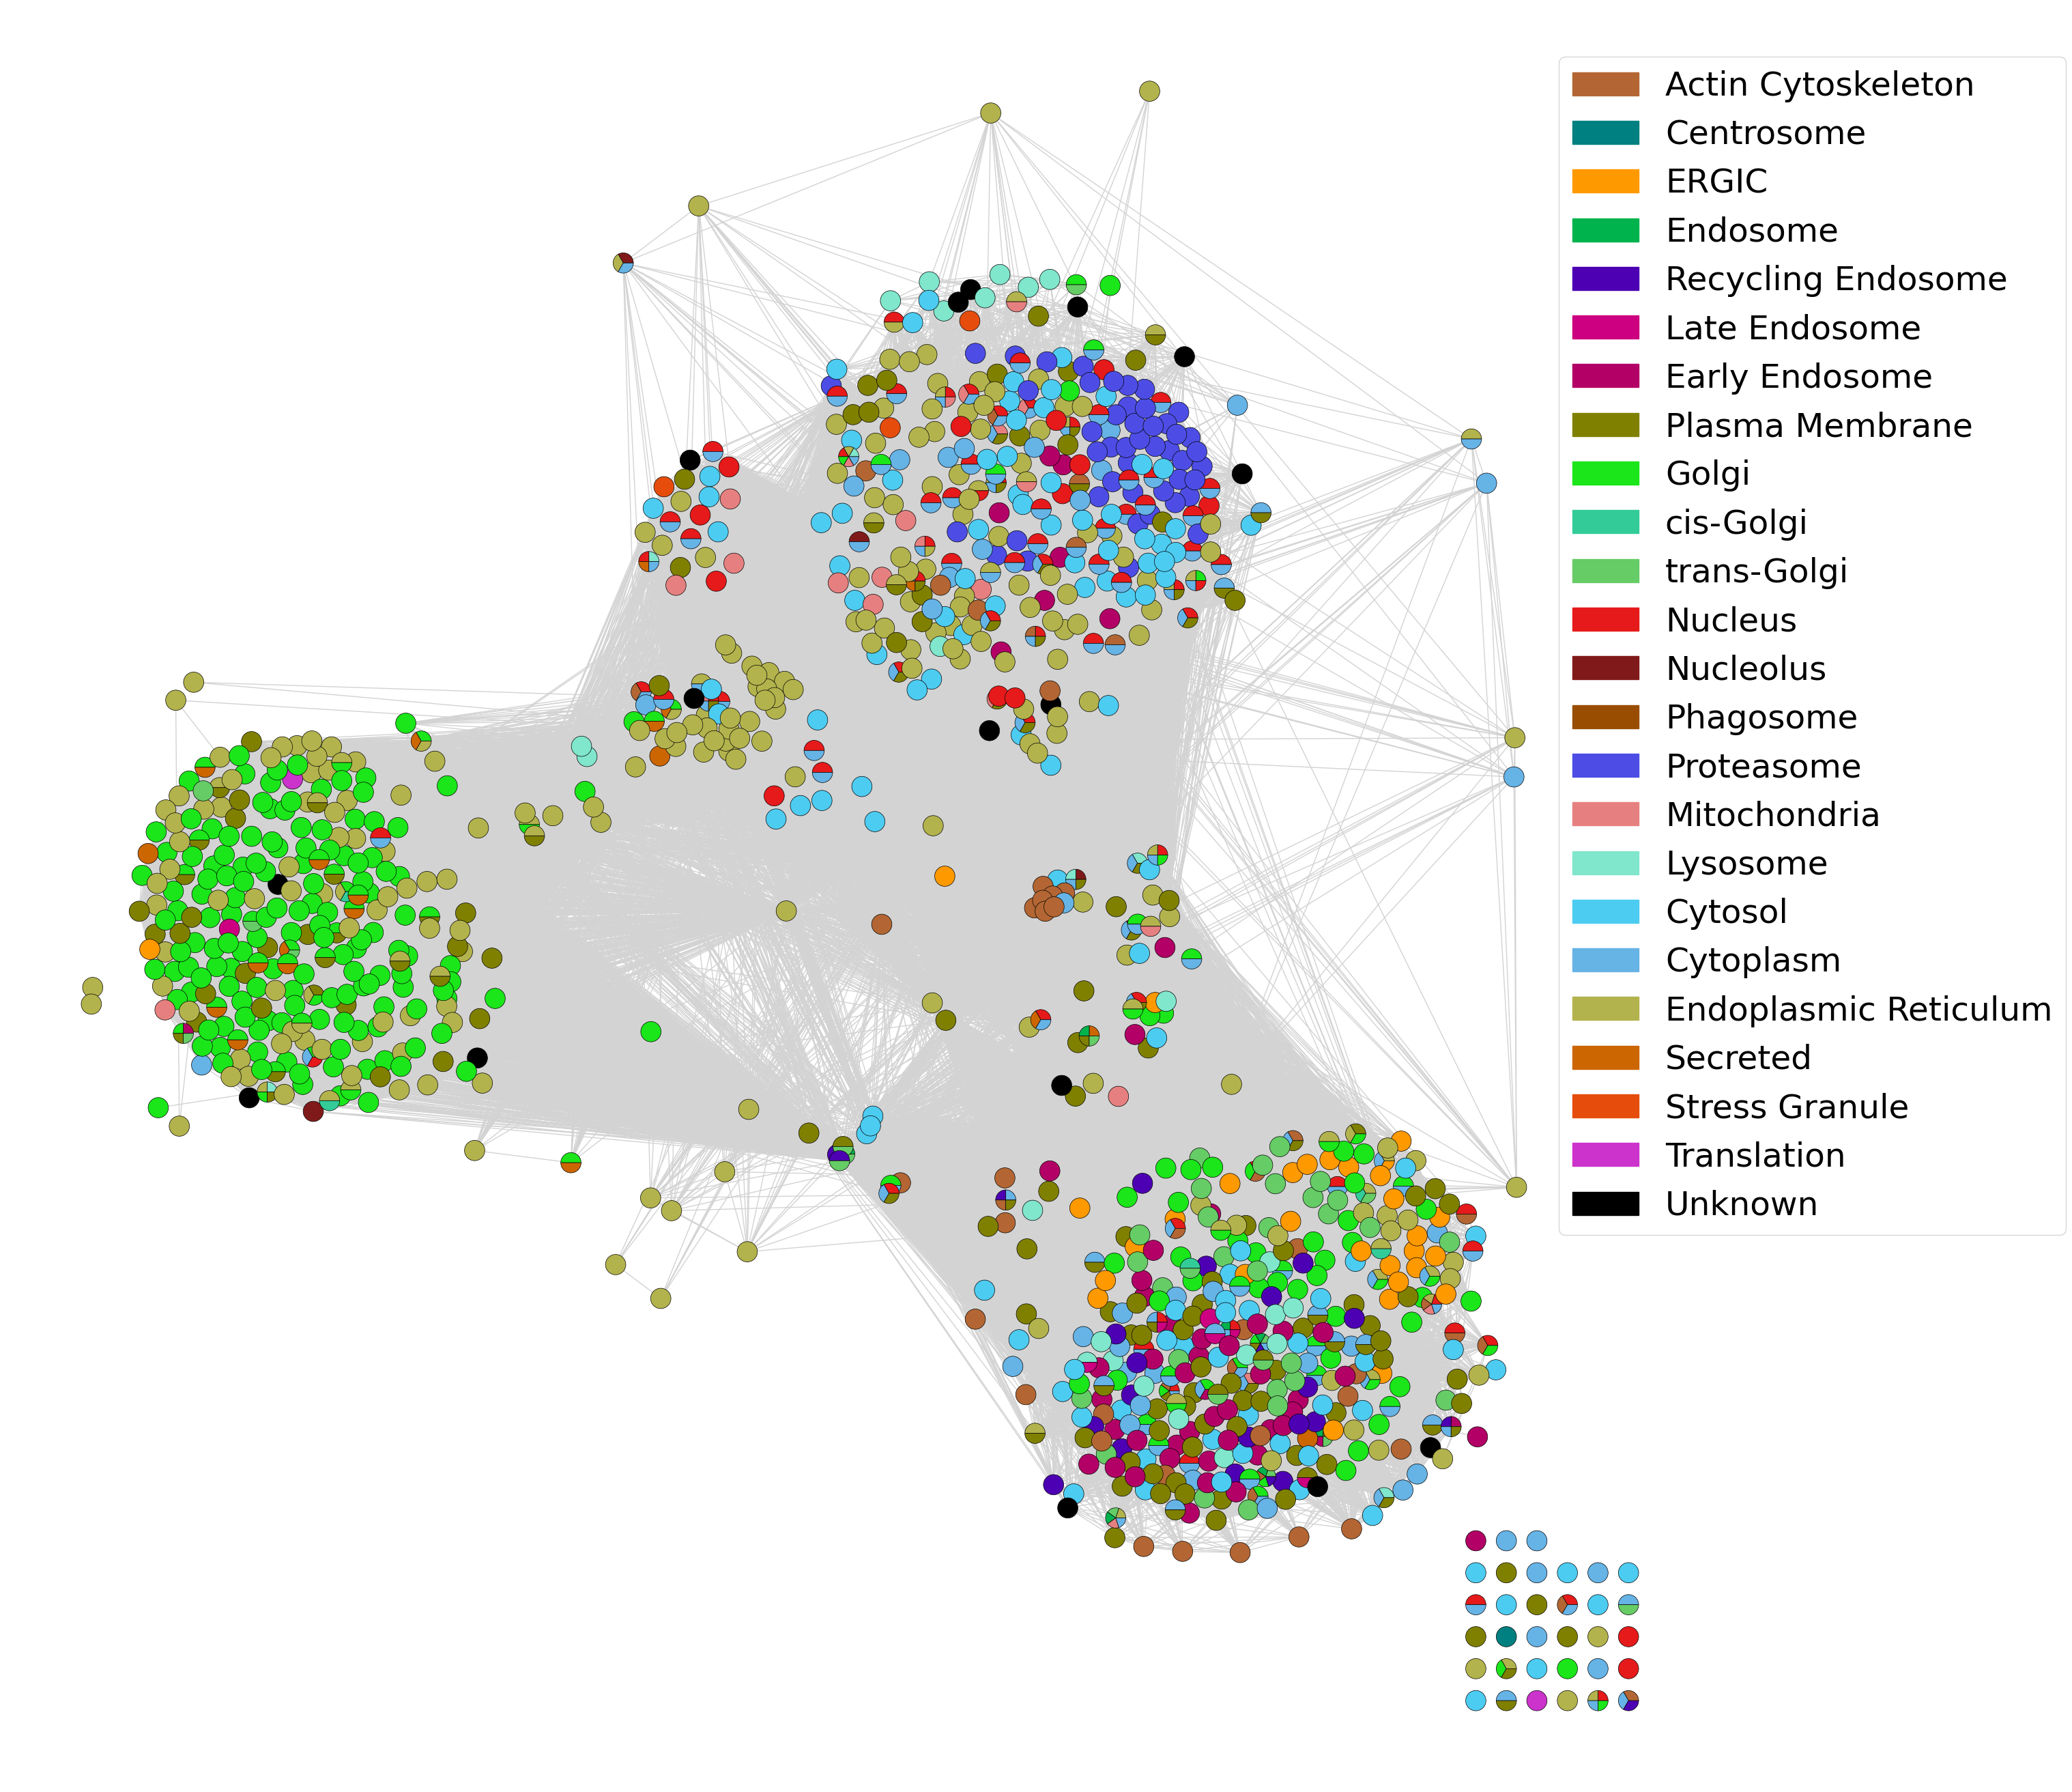

In [11]:
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])


# Draw nodes as pie charts
for node, (x, y) in pos.items():
    localizations = gene_dict[node]['subcellular_localization']
    
    # Adjust the alpha value of each color
    colors = [localization_colors[loc] for loc in localizations]
    
    # Draw pie chart at node position with edgecolor and linewidth
    ax.pie([1]*len(localizations), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in localization_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.9, 0.3))
plt.subplots_adjust(right=0.75)

plt.savefig('Network/secrecon_network_subcellular_comp.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 3.3 Create the plot color-coding by systems

In [15]:
system_colors = {
    'Protein conformation': (1.0, 0.6, 0.0, 1.0),
    'Post-translational modifications': (0.1, 0.9, 0.1, 1.0), 
    'Proteostasis': (0.3, 0.3, 0.9, 1.0),
    'Translocation': (0.4, 0.7, 0.9, 1.0),
    'Vesicle trafficking': (0.7, 0.7, 0.3, 1.0)
}

In [ ]:
radius_coeff = 0.265
# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(40, 40))

# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] >= 1]

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey')#, 
                       #width=[G[u][v]['weight'] for u, v in G.edges() if 40 > G[u][v]['weight'] > 2])

    
# Draw nodes as pie charts
for node, (x, y) in pos.items():
    systems = gene_dict[node]['systems']
    
    # Adjust the alpha value of each color
    colors = [system_colors[sys] for sys in systems]
    
    # Draw pie chart at node position with edgecolor and linewidth
    ax.pie([1]*len(systems), colors=colors, radius=0.012, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    
    #ax.pie([1]*len(systems), colors=colors, radius=radius, center=(x, y), wedgeprops=dict(edgecolor='black', linewidth=0.5))
    #radius = gene_dict[node]['Expression'] * radius_coeff + 0.0000001

# Get the current axis limits
x_values, y_values = zip(*pos.values())
min_x, max_x = min(x_values), max(x_values)
min_y, max_y = min(y_values), max(y_values)

# Set new axis limits
ax.set_xlim(min_x - 0.1, max_x + 0.1)
ax.set_ylim(min_y - 0.1, max_y + 0.1)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in system_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 35}, loc='lower left', bbox_to_anchor=(0.9, 0.6))
plt.subplots_adjust(right=0.75)

plt.savefig('Network/secrecon_network_systems.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

### 3.4 Interactive plotting

In [ ]:
import plotly.graph_objects as go
from itertools import combinations
from plotly.offline import plot
from collections import defaultdict

In [ ]:
def convert_colors_to_rgba(color_dict):
    converted_colors = {}
    for key, (r, g, b, a) in color_dict.items():
        # Convert from 0-1 range to 0-255 range for RGB, keep alpha as is
        r, g, b = [int(255 * x) for x in [r, g, b]]
        converted_colors[key] = f'rgba({r}, {g}, {b}, {a})'
    return converted_colors

# Convert localization_colors to Plotly-compatible format
localization_colors_rgba = convert_colors_to_rgba(localization_colors)

In [ ]:
# 1. Generate Node Traces

#Separate Nodes by Subcellular Localization
nodes_by_localization = defaultdict(list)
for node in G.nodes():
    localizations = gene_dict[node].get('subcellular_localization', ['unknown'])  # Default to 'unknown' if not specified
    for loc in localizations:
        nodes_by_localization[loc].append(node)

# Create one trace per subcellular localization
traces = []
for loc, nodes in nodes_by_localization.items():
    node_x, node_y, node_text = [], [], []
    for node in nodes:
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

        # Construct detailed hover text for each node
        info_parts = [f"{node}"]
        attributes = gene_dict[node]
        for key, values in attributes.items():
            if values:
                if isinstance(values, list):
                    values_str = ', '.join(values)
                else:
                    values_str = values
                info_parts.append(f"{key.capitalize()}: {values_str}")
        node_info = '<br>'.join(info_parts)
        
        node_text.append(node_info)
    
    traces.append(go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            color=localization_colors_rgba.get(loc, 'black'),  # Use the color mapping
            size=20,
            line=dict(width=0.5, color='black')),
        name=loc,  # Name of the trace is the localization
        legendgroup=loc,  # Grouping in the legend
        showlegend=True
    ))


# 2. Generate Edge Trace

# Minimum weight threshold
min_weight_threshold = 1

edge_x = []
edge_y = []
# Filter and generate edge traces
for edge in G.edges(data=True):  # Note the addition of data=True to access edge attributes
    u, v, data = edge
    if data['weight'] >= min_weight_threshold:
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.extend([x0, x1, None])  # 'None' to terminate the line
        edge_y.extend([y0, y1, None])

# Create the edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='rgba(200, 200, 200, 1.0)'),
    hoverinfo='none',
    mode='lines')

# Modify edge_trace to exclude it from the legend
edge_trace.showlegend = False

# 3. Create Plotly Figure and include node_trace in the data parameter
fig = go.Figure(data=[edge_trace] + traces,
                layout=go.Layout(
                    width=1500, # Feel free to change this value as you need for better visualization
                    height=900, # Feel free to change this value as you need for better visualization
                    title='<br><br>',
                    titlefont_size=16,
                    showlegend=True,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))


# Update layout to ensure the legend is visible and properly formatted
fig.update_layout(
    legend=dict(
        title='Subcellular Localization',
        itemsizing='constant',  # Ensures uniform size in legend
        orientation='v',
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.15,
        itemclick='toggleothers'
    )
)

# Display the figure or save to an HTML file
plot(fig, filename='Network/network_graph_interactive.html', auto_open=False)

## 4. Uploading to NDEx

In [12]:
import ndex2

In [13]:
# Function to convert RGBA to Hex
def rgba_to_hex(rgba):
    r, g, b, a = rgba
    return "#{:02x}{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255), int(a*255))

In [16]:
# Add the layout positions and colors to the nodes in the NetworkX graph
for node, (x, y) in pos.items():
    G.nodes[node]['x'] = x
    G.nodes[node]['y'] = y
    systems = gene_dict[node]['systems']
    primary_system = systems[0]
    color = system_colors[primary_system]
    G.nodes[node]['color'] = rgba_to_hex(color)

In [17]:
# Convert the NetworkX graph to CX format
cx_network = ndex2.create_nice_cx_from_networkx(G)

In [18]:
# Create a mapping from node name to node ID in CX network
name_to_cx_id = {data['n']: node_id for node_id, data in cx_network.get_nodes()}

In [19]:
# Add node positions to CX network using the mapping

node_positions = []
for node_name, (x, y) in pos.items():
    cx_node_id = name_to_cx_id[node_name]
    node_positions.append({
        'node': cx_node_id,
        'x': x,
        'y': y
    })
    
# Add node positions to CX network
cx_network.set_opaque_aspect('cartesianLayout', node_positions)

In [20]:
# Prepare the list of node colors in the format required by NDEx

node_colors = []
for node_name, data in G.nodes(data=True):
    cx_node_id = name_to_cx_id[node_name]
    color = data.get('color', '#000000ff')  # Default to black if no color is set
    node_colors.append({
        'po': cx_node_id,  # The node id
        'n': 'nodeColor',  # The attribute name
        'v': color  # The attribute value
    })
    
# Add node colors to CX network
cx_network.set_opaque_aspect('nodeAttributes', node_colors)

In [21]:
# Your NDEx account credentials
username = 'pablodigiusto91@gmail.com'
password = '?5QlU1z4=4'
server = 'http://public.ndexbio.org'

In [22]:
# Create an NDEx client
ndex_client = ndex2.client.Ndex2(server, username, password)

# Upload the network to NDEx
network_uuid = ndex_client.save_new_network(cx_network.to_cx())

print(f'Network uploaded successfully. Network UUID: {network_uuid}')

Generating CX
Network uploaded successfully. Network UUID: https://www.ndexbio.org/v2/network/70fbd7d3-4def-11ef-a7fd-005056ae23aa
